> Name: Tinh Ta

> Student number: 887294

# 1. Importing neccessary libraries

In [105]:
#pip install psycopg2-binary

In [106]:
#pip install sqlalchemy_utils

In [1]:
import sys
import pandas as pd
import numpy as np
import time, os
from sqlalchemy import create_engine, event, schema, Table, text, Null,Column, String, Date, Float, Integer, MetaData, CheckConstraint, ForeignKeyConstraint,VARCHAR, NUMERIC, PrimaryKeyConstraint, ForeignKey
from sqlalchemy_utils import database_exists, create_database
from sqlalchemy.orm import sessionmaker
import psycopg2
from psycopg2 import Error
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data cleaning and dataframe creation (Question 2)

In [76]:
# Read the csv file
df = pd.read_csv('weather_data_2020.csv')

In [77]:
# Create the date column in the dataframe
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [78]:
# Replace -1 value in the 'rain' and 'snow' columns with 0 
columns = ['rain','snow']
for column in columns:
    df.loc[df[column] == -1, column] = 0

> 2.1 Create the Place dataframe to insert into Place table of the database

In [79]:
df_place = df[['place_code','place','latitude','longitude'] # Select these columns from the orginal dataframe
              ].rename(columns = {'place_code':'code',
                                  'place' : 'name'}) # Rename the columns to match with the designed table
df_place = df_place.drop_duplicates().reset_index().drop(columns = 'index')#.replace(np.nan, Null) # Drop duplicates value and reset and drop the index
df_place.head() # The resulted dataframe

,code,name,latitude,longitude
0,100968,Helsinki-Vantaa Airport,60.32670,24.95675
1,102035,Utsjoki,69.75637,27.00678
2,101464,Mustasaari,63.43508,21.06856
3,101649,Pötsönvaara,63.14167,31.04438


> 2.2 Create Observation dataframe to insert into Observation table of the database

In [80]:
df_obs = df[['place_code', 
             'date',
             'rain',
             'snow',
             'air_temperature',
             'ground_temperature'] # Select the relevant columns in the original dataframe
            ].rename(columns = {'place_code':'place'} # Rename the column(s) to matched with the designed table in the database
                     ).groupby(['place', 'date'] # Group by the primary keys attributes
                               ).agg(
                                   {    
                                       'rain':'mean', 
                                       'snow':'mean',
                                       'air_temperature':'mean',
                                       'ground_temperature':'mean' # Aggregate by taking the mean of rain, snow, air_temperature, and ground_temperature
                                   } 
                               ).reset_index().round(1)#.replace(np.nan, Null) # reset_index and round the values to 1 decimal place


In [81]:
# The resulted dataframe
df_obs.head()

,place,date,rain,snow,air_temperature,ground_temperature
0,100968,2020-01-01,0.0,0.0,1.0,-4.0
1,100968,2020-01-02,0.0,0.0,2.9,-0.4
2,100968,2020-01-03,0.8,0.0,4.3,2.8
3,100968,2020-01-04,0.1,0.0,1.0,-2.5
4,100968,2020-01-05,4.0,0.0,-2.1,-1.9


> 2.3 Create Temperature dataframe to insert into the Temperature table of the database

In [82]:
df_temp = df[[
    'place_code',
    'date',
    'lowest_temperature',
    'highest_temperature' # Select the relavent columns
]].rename(columns = 
          {'highest_temperature':'highest',
            'lowest_temperature': 'lowest',
            'place_code': 'place'}  # Rename the columns to match with the designed table
            ).groupby(['place','date']
                      ).agg({
                          'highest' :'max',
                          'lowest' : 'min' # Aggregate the values 
                      }
                      ).reset_index().round(1)#.replace(np.nan, Null) # Reset the index and round the value 1 decimal place

In [83]:
# The resulted dataframe
df_temp.head()

,place,date,highest,lowest
0,100968,2020-01-01,2.9,-2.5
1,100968,2020-01-02,4.2,1.0
2,100968,2020-01-03,5.4,3.8
3,100968,2020-01-04,4.4,-0.8
4,100968,2020-01-05,1.8,-6.6


# 3. Database and table creation (Question 1)

> 3.1 Create weatherdata database

In [5]:
# Define your PostgreSQL connection parameters
user =  # Insert here
password =  # Insert here
host =  # Insert here
port =  # Insert here
dbname =   # Insert here

# Create the database URL
db_url = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create an engine instance
engine = create_engine(db_url)

# Check if the database exists, and if not, create it
if not database_exists(engine.url):
    create_database(engine.url)
    print(f"Database '{dbname}' created successfully.")
else:
    print(f"Database '{dbname}' already exists.")

# Connect to the database
con = engine.connect()
print(f"Connected to the database '{dbname}' successfully.")

# Closing the connection
con.close()

Database 'weatherdata' already exists.
Connected to the database 'weatherdata' successfully.


In [6]:
# Assuming you have already defined your SQLAlchemy engine
engine = create_engine(db_url)

# Get the database connection URI
uri = str(engine.url)

# Establish a connection using psycopg2
conn = psycopg2.connect(uri)

# Create a cursor
cursor = conn.cursor()

# Execute the raw SQL query
cursor.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

# Commit the transaction
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()


OperationalError: connection to server at "localhost" (::1), port 5432 failed: FATAL:  password authentication failed for user "postgres"


> 3.2 Create the tables

In [85]:
metadata = MetaData()

Place = Table(
    'Place', metadata,
    Column('code',VARCHAR(6), primary_key= True, nullable = False),
    Column('name', VARCHAR, nullable = False),
    Column('latitude', NUMERIC(precision = 8, scale = 6), nullable= False),
    Column('longitude', NUMERIC(precision = 9, scale = 6), nullable = False)
)

Observation = Table(
    'Observation', metadata,
    Column('place', VARCHAR(6), ForeignKey('Place.code'),nullable = False),
    Column('date', Date, nullable = False),
    Column('rain', NUMERIC(scale = 1), default = Null),
    Column('snow', NUMERIC(scale = 1), default = Null),
    Column('air_temperature', NUMERIC(scale = 1), default = Null),
    Column('ground_temperature', NUMERIC(scale = 1), default = Null),
    PrimaryKeyConstraint('place','date')
)

Temperature = Table(
    'Temperature', metadata,
    Column('place', VARCHAR(6), ForeignKey('Place.code'), nullable = False),
    Column('date', Date, nullable = False),
    Column('lowest', NUMERIC(scale = 1), default = Null),
    Column('highest', NUMERIC(scale = 1), default = Null),
    PrimaryKeyConstraint('place','date')
)

metadata.create_all(engine)

> 3.3 Insert the value into database

In [87]:
con = engine.connect() 

dataframes = {
    'Place' : {
        'dataframe': df_place,
        'table_name': 'Place',
        'if_exists' : 'append' 
    },
    'Observation' : {
        'dataframe': df_obs,
        'table_name': 'Observation',
        'if_exists' : 'append' 
    },
    'Temperature' : {
        'dataframe': df_temp,
        'table_name': 'Temperature',
        'if_exists' : 'append' 
    }
}

for key, value in dataframes.items():
    dataframe = value['dataframe']
    table_name = value['table_name']
    if_exists = value['if_exists']

    dataframe.to_sql(table_name, con, if_exists = if_exists, index = False)

con.commit()
con.close()

# Question 3

## a 

> The number of of snowy days for each location and the location with the most snowy days

In [89]:
# Define the query
query = """
    SELECT place, 
            name,
           SUM(CASE WHEN snow IS NOT NULL AND snow > 0 THEN 1 END) AS snowy_days 
    FROM "Observation" o
    join "Place" p on  p.code = o.place
    GROUP BY place, name
    HAVING SUM(CASE WHEN snow IS NOT NULL AND snow > 0 THEN 1 END) IS NOT NULL
    ORDER BY snowy_days desc;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_count_snowy_days = pd.read_sql_query(text(query), con)

print("The number of snowy days for each location: \n")
print(df_count_snowy_days, "\n")

print(f"The location with the highest days of snow is {df_count_snowy_days['name'][0]} with a total of {df_count_snowy_days['snowy_days'][0]} snowy days")


The number of snowy days for each location: 

    place                     name  snowy_days
0  102035                  Utsjoki         218
1  101649              Pötsönvaara          48
2  100968  Helsinki-Vantaa Airport           8 

The location with the highest days of snow is Utsjoki with a total of 218 snowy days


> The location with the highest number of snow days and the month with the most snow

In [90]:
# Define the query
query = """
    SELECT p.name,
        extract (year from date) as year,
       EXTRACT(MONTH FROM date) AS month,
       SUM(snow) AS total_snow
    FROM "Observation" o
    join "Place" p on o.place = p.code 
    WHERE place in (
        SELECT place
        FROM "Observation" 
        GROUP BY place
        having sum(CASE WHEN snow IS NOT NULL and snow <> 0 THEN 1 END) is not null
        order by COUNT(CASE WHEN snow IS NOT NULL AND snow <> 0 THEN 1 END) desc
        limit 1
    )
    GROUP BY p.name, year, month
    ORDER BY total_snow desc
    LIMIT 1;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_most_snow_month = pd.read_sql_query(text(query), con)
    df_most_snow_month['month'] = pd.to_datetime(df_most_snow_month['month'], format='%m')
    df_most_snow_month['month'] = df_most_snow_month['month'].dt.strftime('%B')

print(f"{df_most_snow_month['month'][0]} is the month with the most snow for {df_most_snow_month['name'][0]} with a total of {df_most_snow_month['total_snow'][0].astype(int)} cm of snow")

March is the month with the most snow for Utsjoki with a total of 2924 cm of snow


> The location with least snowy days and the month with most snowy days of that location (assumming least snowy days > 0)

In [91]:
# Define the query
query = """
        SELECT  p.name,
                extract (year from date) as year,
                EXTRACT(MONTH FROM date) AS month,
                sum(case when snow is not null and snow > 0 then 1 end) AS snow_days
        FROM "Observation" o
        join "Place" p on o.place = p.code 
        WHERE place in (
            SELECT place
            FROM "Observation" 
            GROUP BY place
            having sum(CASE WHEN snow IS NOT NULL and snow > 0 THEN 1 END) is not null
            order by sum(CASE WHEN snow IS NOT NULL AND snow > 0 THEN 1 END) asc
            limit 1
        )
        GROUP BY p.name, year, month
        HAVING sum(case when snow is not null and snow > 0 then 1 end) IS NOT NULL
        order by snow_days desc
        LIMIT 1;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_month_with_most_snow_days = pd.read_sql_query(text(query), con)
    df_month_with_most_snow_days['month'] = pd.to_datetime(df_month_with_most_snow_days['month'], format='%m')
    df_month_with_most_snow_days['month'] = df_month_with_most_snow_days['month'].dt.strftime('%B')

print(f"{df_month_with_most_snow_days['name'][0]} is the location with the least number of snowy days > 0 with {df_month_with_most_snow_days['month'][0]} as the month with the most snowy days of {df_month_with_most_snow_days['snow_days'][0]} days")

Helsinki-Vantaa Airport is the location with the least number of snowy days > 0 with April as the month with the most snowy days of 3 days


## b

> Correlation between highest and lowest temperature

In [92]:
# Define the query
query = """
    WITH temp AS (
    SELECT place, date, lowest, highest
    FROM "Temperature" 
    WHERE lowest IS NOT NULL AND highest IS NOT NULL
    )
    SELECT ROUND(cast(CORR(lowest, highest) as numeric), 2) AS corr_coef
    FROM temp;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    corr_coef_highest_lowest = pd.read_sql_query(text(query), con)

print(f"The correlation between highest and lowest temperature is: {corr_coef_highest_lowest['corr_coef'][0]}")

The correlation between highest and lowest temperature is: 0.9


=> The high correlation between highest and lowest temperature mean that as lowest temperature increases, the highest temperature will also increase.

> Correlation between highest and lowest temperature group by location

In [93]:
# Define the query
query = """
    WITH temp AS (
    SELECT place, name, date, lowest, highest
    FROM "Temperature" t
    JOIN "Place" p on t.place = p.code
    WHERE t.lowest IS NOT NULL AND t.highest IS NOT NULL
    )
    SELECT name, 
            ROUND(cast(CORR(lowest, highest) as numeric), 2) AS corr_coef
    FROM temp
    GROUP BY name;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    corr_coef_by_location = pd.read_sql_query(text(query), con)

print(f"The correlation between highest and lowest temperature group by location is:")
print(corr_coef_by_location)

The correlation between highest and lowest temperature group by location is:
                      name  corr_coef
0                  Utsjoki       0.90
1               Mustasaari       0.96
2  Helsinki-Vantaa Airport       0.90
3              Pötsönvaara       0.95


## C

In [94]:
# Define the query
query = """
        WITH temp AS (
        SELECT p.latitude,
                AVG(o.air_temperature) AS avg_temperature
        FROM "Observation" o
        JOIN "Place" p ON o.place = p.code
        WHERE o.air_temperature IS NOT NULL
        GROUP BY p.latitude
        )
        SELECT ROUND(cast(CORR(latitude, avg_temperature) as numeric), 2) AS corr_coef
        FROM temp;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_3c = pd.read_sql_query(text(query), con)

print(f"Correlation coeficient between average temperature and latitude is: {df_3c['corr_coef'][0]}")

Correlation coeficient between average temperature and latitude is: -0.96


## D

In [95]:
# Define the query
query = """
        SELECT place, 
                    name, 
                    extract (month from date) as month,
                    sum(CASE WHEN rain IS NOT NULL and rain > 0 THEN 1 else 0 end) AS rainy_days
        FROM "Observation" o
        join "Place" p on p.code = o.place
        GROUP BY place, name, month
        HAVING sum(CASE WHEN rain IS NOT NULL and rain > 0 THEN 1 else 0 end) > 0
        order by place, name, month;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_3d = pd.read_sql_query(text(query), con)
    df_3d['month'] = df_3d['month'].astype(int).astype('category')

# Display the DataFrame
print(df_3d)

     place                     name month  rainy_days
0   100968  Helsinki-Vantaa Airport     1          22
1   100968  Helsinki-Vantaa Airport     2          19
2   100968  Helsinki-Vantaa Airport     3          16
3   100968  Helsinki-Vantaa Airport     4          14
4   100968  Helsinki-Vantaa Airport     5          11
5   100968  Helsinki-Vantaa Airport     6           9
6   100968  Helsinki-Vantaa Airport     7          21
7   100968  Helsinki-Vantaa Airport     8          13
8   100968  Helsinki-Vantaa Airport     9          15
9   100968  Helsinki-Vantaa Airport    10          24
10  100968  Helsinki-Vantaa Airport    11          17
11  100968  Helsinki-Vantaa Airport    12          25
12  101649              Pötsönvaara     6           5
13  101649              Pötsönvaara     7          18
14  101649              Pötsönvaara     8          17
15  101649              Pötsönvaara     9          16
16  101649              Pötsönvaara    10          24
17  101649              Pöts

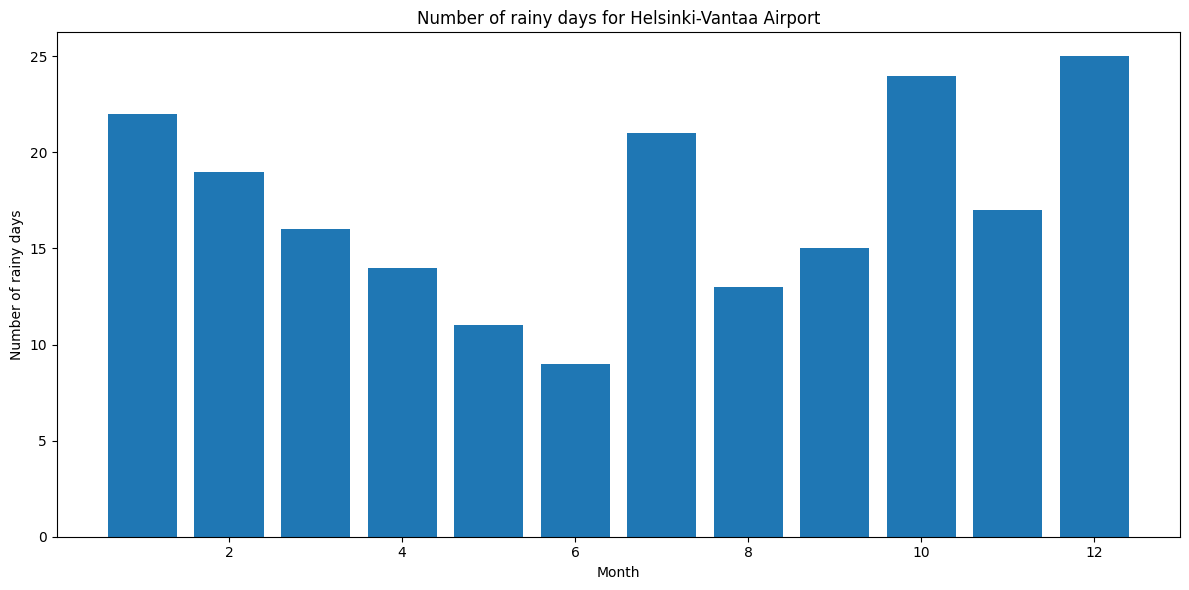

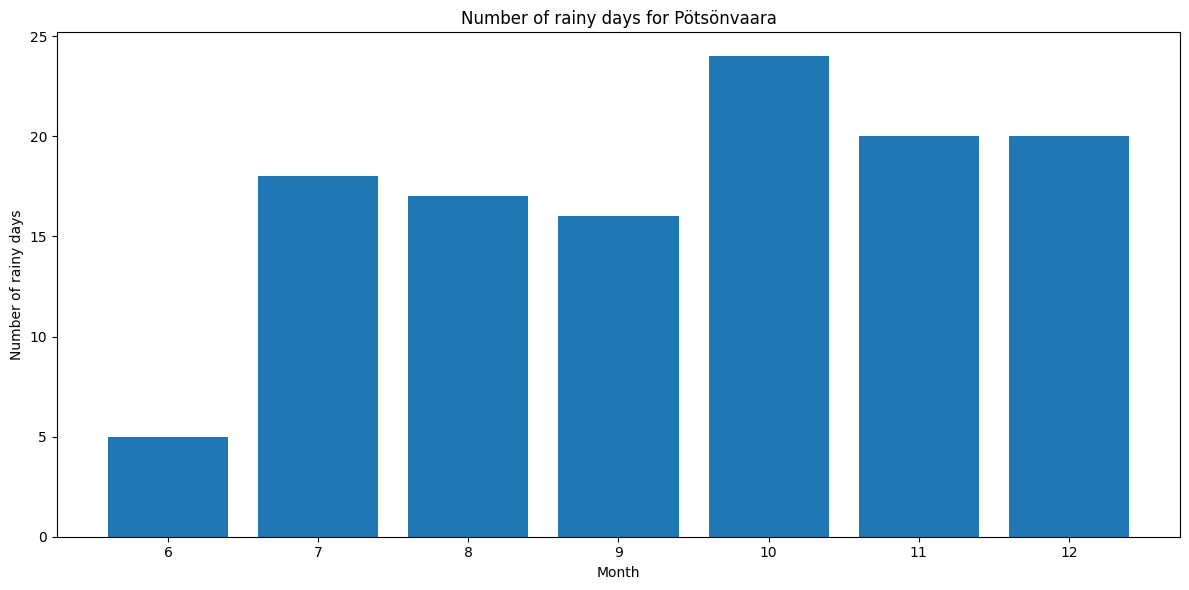

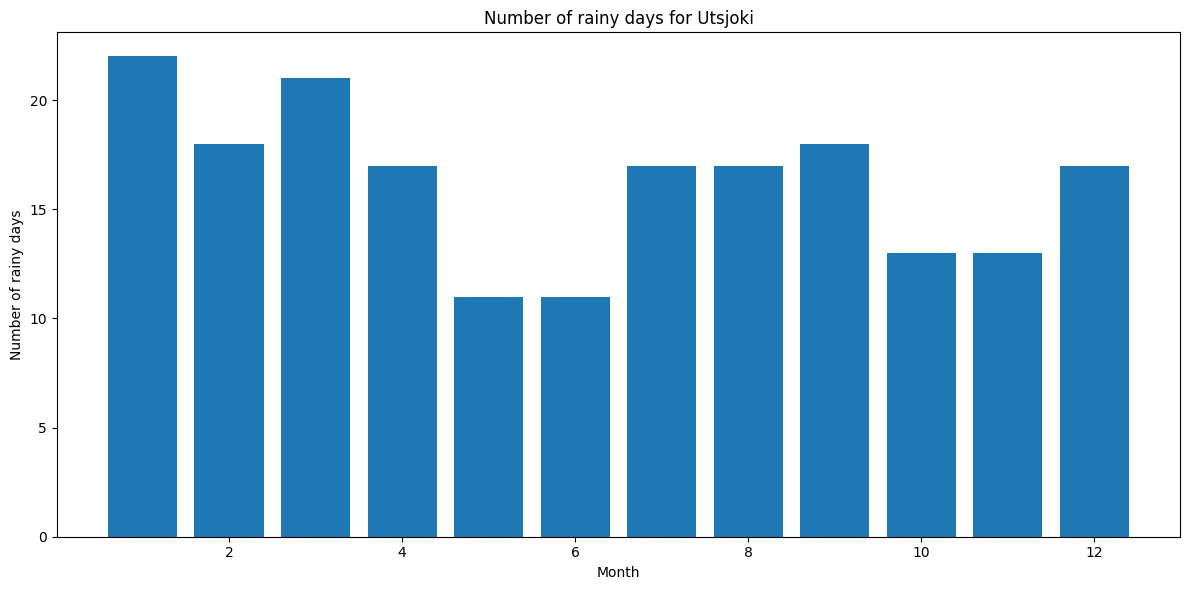

In [96]:
for element in df_3d['name'].unique():
    df_d = df_3d[df_3d['name']==element]
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.bar(df_d['month'],height = df_d['rainy_days'])
    plt.xlabel('Month')
    plt.ylabel('Number of rainy days')
    plt.title(f'Number of rainy days for {element}')
    plt.tight_layout()
    plt.show()

## E

In [97]:
# Define the query
query = """
        select place, 
            name, 
            date,
            o.air_temperature AS avg_temperature
        from "Observation" o 
        join "Place" p ON p.code = o.place
        order by place, name, date; 
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_3e_daily = pd.read_sql_query(text(query), con)

# Display the DataFrame
print(df_3e_daily)

       place                     name        date  avg_temperature
0     100968  Helsinki-Vantaa Airport  2020-01-01              1.0
1     100968  Helsinki-Vantaa Airport  2020-01-02              2.9
2     100968  Helsinki-Vantaa Airport  2020-01-03              4.3
3     100968  Helsinki-Vantaa Airport  2020-01-04              1.0
4     100968  Helsinki-Vantaa Airport  2020-01-05             -2.1
...      ...                      ...         ...              ...
1293  102035                  Utsjoki  2020-12-27            -33.5
1294  102035                  Utsjoki  2020-12-28             -9.1
1295  102035                  Utsjoki  2020-12-29             -3.8
1296  102035                  Utsjoki  2020-12-30             -3.9
1297  102035                  Utsjoki  2020-12-31             -4.0

[1298 rows x 4 columns]


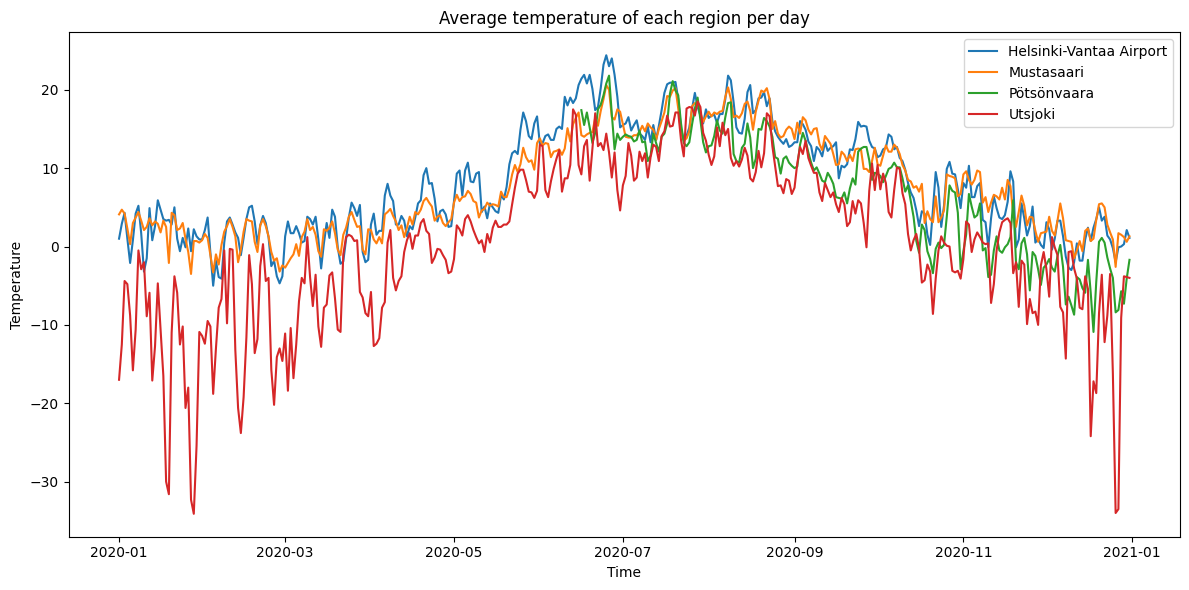

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))

for element in df_3e_daily['name'].unique():
    df_e = df_3e_daily[df_3e_daily['name']==element]
    x = df_e['date']  # Get the 'date' column values
    y = df_e['avg_temperature']  # Get the 'avg_temperature' column values
    ax.plot(x, y, label=element)

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Average temperature of each region per day')
ax.legend()
plt.tight_layout()
plt.show()

In [99]:
# Define the query
query = """
        select place, 
            name, 
            extract (month from date) as month,
            AVG(o.air_temperature) AS avg_temperature
        from "Observation" o 
        join "Place" p ON p.code = o.place
        group by place, name, month
        order by place, name, month; 
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df_3e_monthly = pd.read_sql_query(text(query), con)
    df_3e_monthly['month'] = df_3e_monthly['month'].astype(int).astype('category')

# Display the DataFrame
print(df_3e_monthly)

     place                     name month  avg_temperature
0   100968  Helsinki-Vantaa Airport     1         1.922581
1   100968  Helsinki-Vantaa Airport     2         0.506897
2   100968  Helsinki-Vantaa Airport     3         1.745161
3   100968  Helsinki-Vantaa Airport     4         4.540000
4   100968  Helsinki-Vantaa Airport     5         9.487097
5   100968  Helsinki-Vantaa Airport     6        18.446667
6   100968  Helsinki-Vantaa Airport     7        16.496774
7   100968  Helsinki-Vantaa Airport     8        16.767742
8   100968  Helsinki-Vantaa Airport     9        12.983333
9   100968  Helsinki-Vantaa Airport    10         8.161290
10  100968  Helsinki-Vantaa Airport    11         4.363333
11  100968  Helsinki-Vantaa Airport    12         0.874194
12  101464               Mustasaari     1         2.183871
13  101464               Mustasaari     2         0.582759
14  101464               Mustasaari     3         1.096774
15  101464               Mustasaari     4         3.3200

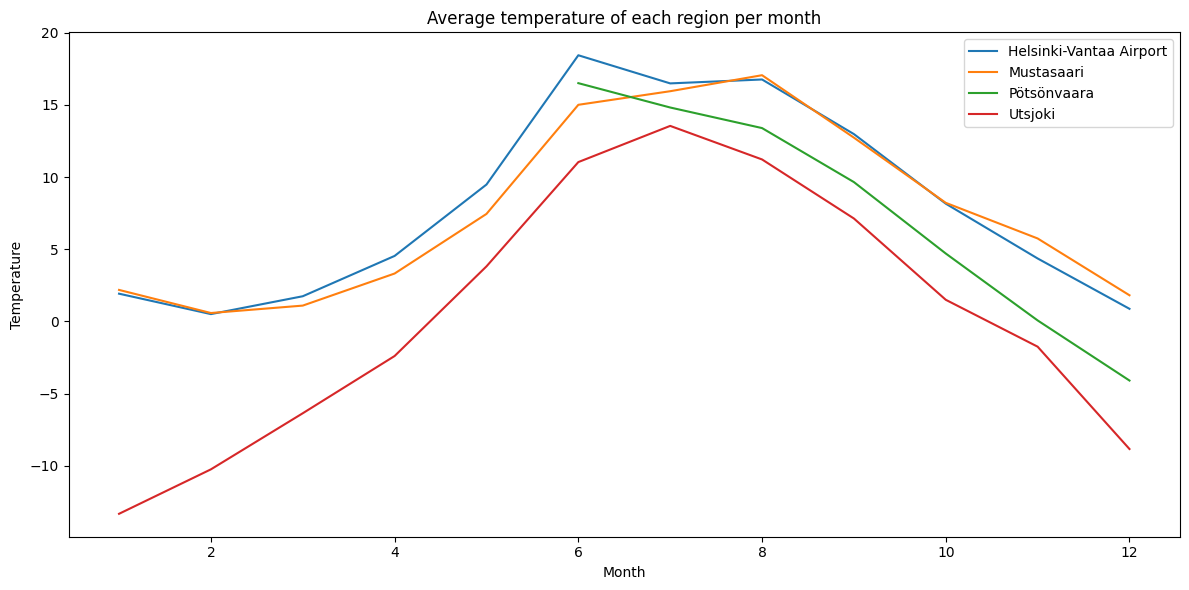

In [100]:
fig, ax = plt.subplots(figsize=(12, 6))

for element in df_3e_monthly['name'].unique():
    df_e = df_3e_monthly[df_3e_monthly['name']==element]
    x = df_e['month']  # Get the 'month' column values
    y = df_e['avg_temperature']  # Get the 'avg_temperature' column values
    ax.plot(x, y, label=element)

ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
ax.set_title('Average temperature of each region per month')
ax.legend()
plt.tight_layout()
plt.show()

In [101]:
con.close()